# Training

## Setup

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 128
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True

# Normalize input images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

In [4]:
T = 1000
beta_start, beta_end = 1e-4, 2e-2
beta = torch.linspace(beta_start, beta_end, T)  # Linear noise schedule
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# Reshape for broadcasting (if required for your model)
alpha = alpha.view((T, 1, 1, 1)).to(device)
beta = beta.view((T, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


## Model

In [5]:
import math
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        freqs = torch.exp(
            -torch.arange(half_dim, dtype=torch.float32) * math.log(10000) / half_dim
        ).to(t.device)
        angles = t[:, None] * freqs[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

In [6]:
class LinearTimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(LinearTimeEmbedding, self).__init__()
        self.projection = nn.Linear(1, embedding_dim)  # Project the scalar to the embedding dimension

    def forward(self, t):
        return self.projection(t.unsqueeze(-1))  # Add an extra dimension for the projection


In [ ]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [32, 64, 128, 256]
        
        # Define convolutional layers for encoding
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=1),  # (batchsize, 128, 4, 4)
                nn.Conv2d(channels[2], channels[3], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.ReLU(),
            )
        ])

        # Define transpose convolutional layers for decoding
        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, 
                                   stride=2, padding=1, output_padding=0),   # (batchsize, 128, 7, 7)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0], 1, kernel_size=1)  # (batchsize, 1, 28, 28)
            )      
        ])
        
        # Linear layer to process the time embedding
        self.lin_time = nn.Linear(128, channels[3])

    def forward(self, x, t_emb):
        signal = x
        signals = []

        # Pass through the encoding layers
        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            signal = conv(signal)
            # print(signal.shape)
            if i < len(self.convs)-1:
                signals.append(signal)  # Store intermediate feature maps for skip connections

        # Process time embedding and match dimensions
        t_emb_processed = self.lin_time(t_emb).view(-1, 256, 1, 1)  # Map time embedding to match the feature map shape
        
        # Add time embedding to the bottleneck signal (this could be done at any point during the decoder)
        signal = signal + t_emb_processed  # Broadcast and add to the signal in the bottleneck

        # Pass through the decoding layers with skip connections and time-embedded signal
        for i, tconv in enumerate(self.tconvs):
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                signal = tconv(signal)
            else:
                # print(f"signals[{-i}] shape: {signals[-i].shape}")
                signal = torch.cat((signal, signals[-i]), dim=-3)  # Skip connection
                signal = tconv(signal)

        return signal



## Training loop

In [12]:
#from UNET import UNET
epochs = 200
model = UNET().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
running_loss = 0


# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)


In [ ]:

# Training loop
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)

        # Sample timesteps and noise
        t = torch.randint(0, T, (batch_size,), device=device).float()
        
        # Compute the time embedding
        t_emb = time_embedding_layer(t)  # Shape: [batch_size, embedding_dim]
        
        eps = torch.randn_like(x0).to(device)

        # Generate noisy inputs
        x_t = torch.sqrt(alpha_bar[t.long()]) * x0 + torch.sqrt(1 - alpha_bar[t.long()]) * eps

        # Forward pass
        predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model

        # Compute loss
        loss = criterion(predicted_eps, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if e % 100 == 99:
            print(f"Epoch {epoch}, Batch {e+1}, Average Loss: {running_loss / 100:.4f}")
            running_loss = 0.0  

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"DDPM_{epoch+1}.pth")

# Sampling

In [ ]:
load_model = None

if load_model:
    model.load_state_dict(torch.load(load_model, map_location=device))
with torch.inference_mode():
    model.eval()
    batch_size = 1
    xt = torch.randn(batch_size, 1, 28, 28).to(device)

    for t in torch.arange(T, 0, -1):
        t = t.reshape(1)
        t = t.to(device)
        t_emb = time_embedding_layer(t.float())
        z = torch.randn(batch_size, 1, 28, 28).to(device) if t > 1 else torch.zeros(batch_size, 1, 28, 28).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                    model(xt, t_emb)) + torch.sqrt(beta[t-1]) * z
        xt = xt_new


plt.imshow(xt[0][0].cpu().detach().numpy(), cmap="grey")

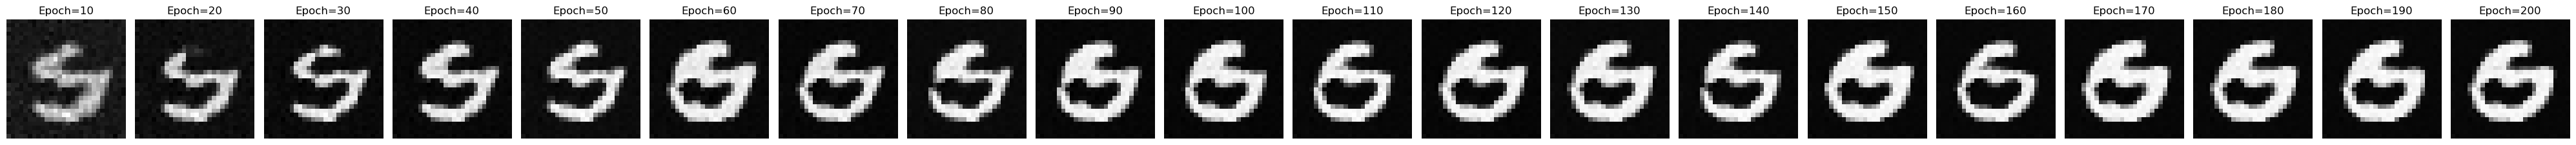

In [23]:
# sample from all the timesteps
fig, axs = plt.subplots(1, 20, tight_layout=True, figsize=(40, 20))
tens = np.arange(10,201,10)
seed = 3546
for ten in tens:
    with torch.inference_mode():
        torch.manual_seed(seed)
        model.load_state_dict(torch.load(f"DATA_FROM_training-markus/DDPM_{ten}.pth", map_location=device))
        model.eval()
        batch_size = 1
        xt = torch.randn(batch_size, 1, 28, 28).to(device)

        for t in torch.arange(T, 0, -1):
            t = t.reshape(1)
            t = t.to(device)
            t_emb = time_embedding_layer(t.float())
            z = torch.randn(batch_size, 1, 28, 28).to(device) if t > 1 else torch.zeros(batch_size, 1, 28, 28).to(device)
            
            xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                        model(xt, t_emb)) + torch.sqrt(beta[t-1]) * z
            xt = xt_new
        axs[(ten//10)-1].imshow(xt[0][0].cpu().detach().numpy(), cmap="gray")
        axs[(ten//10)-1].axis("off")
        axs[(ten//10)-1].set_title(f"Epoch={ten}")
plt.show()